In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
import editdistance
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from google.colab import drive
drive.mount('/content/gdrive/')

%matplotlib inline

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/cirrhosis

/content/gdrive/MyDrive/cirrhosis


#Loading Data

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
df = df.dropna()

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#Spliting Into Train, Test, Valid

In [6]:
msk = np.random.rand(len(df)) < 0.6


In [7]:
train_df = df[msk]
test_df = df[~msk]
msk_val = np.random.rand(len(test_df)) < 0.5
val_df = test_df[msk_val]
test_df = test_df[~msk_val]

In [8]:
print('Training set len:',len(train_df))
print('Testing set len:',len(test_df))
print('Validation set len:',len(val_df))

Training set len: 460
Testing set len: 167
Validation set len: 141


In [10]:
train_df.head(6)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1


In [11]:
X_train , y_train = np.array(train_df.drop(['Outcome'],axis = 1)), np.array(train_df['Outcome'])
X_test , y_test = np.array(test_df.drop(['Outcome'],axis = 1)), np.array(test_df['Outcome'])
X_val , y_val = np.array(val_df.drop(['Outcome'],axis = 1)), np.array(val_df['Outcome'])

In [12]:
X_train.shape , y_train.shape

((460, 8), (460,))

In [13]:
X_test.shape , y_test.shape

((167, 8), (167,))

In [14]:
X_val.shape , y_val.shape


((141, 8), (141,))

*Pre-processeing*

In [15]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [16]:
s_scaler = preprocessing.MinMaxScaler(feature_range=(0,20))
X_scaled= s_scaler.fit_transform(X_train)

X_train = X_scaled
X_val = s_scaler.fit_transform(X_val)
X_test =  s_scaler.fit_transform(X_test)

In [20]:
max_seq_length = 8
X_train_padded = sequence.pad_sequences(X_train, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(np.array(X_val), maxlen=max_seq_length, padding='post')
X_test_padded = sequence.pad_sequences(np.array(X_test), maxlen=max_seq_length, padding='post')

In [21]:
X_train_padded.shape

(460, 8)

In [22]:
X_val_padded.shape

(141, 8)

In [23]:
X_val_padded[0]

array([ 8, 15, 13, 14,  0, 12,  5, 11], dtype=int32)

*Training Model*

In [66]:
vocab_size = 1100
# Add Input layer
inputs = keras.Input(shape=(None,), dtype="int32")

# Add embedding layer
x = layers.Embedding(vocab_size, 128)(inputs)

# Add LSTM layers
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add fully connected layer
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create Model
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 128)         140800    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainab

In [67]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [68]:
model.compile(Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'], )


In [69]:
history = model.fit(X_train_padded, y_train, epochs = 30, batch_size =8, validation_data=(X_val_padded, y_val),callbacks = [early_stop])


Epoch 1/30
58/58 [==============================] - 10s 55ms/step - loss: 0.6573 - accuracy: 0.6413 - val_loss: 0.5500 - val_accuracy: 0.6950
Epoch 2/30
58/58 [==============================] - 1s 18ms/step - loss: 0.5785 - accuracy: 0.6630 - val_loss: 0.4929 - val_accuracy: 0.7730
Epoch 3/30
58/58 [==============================] - 1s 19ms/step - loss: 0.5144 - accuracy: 0.7304 - val_loss: 0.5251 - val_accuracy: 0.7092
Epoch 4/30
58/58 [==============================] - 1s 18ms/step - loss: 0.5113 - accuracy: 0.7457 - val_loss: 0.4912 - val_accuracy: 0.7730
Epoch 5/30
58/58 [==============================] - 1s 18ms/step - loss: 0.4637 - accuracy: 0.7478 - val_loss: 0.5437 - val_accuracy: 0.7518


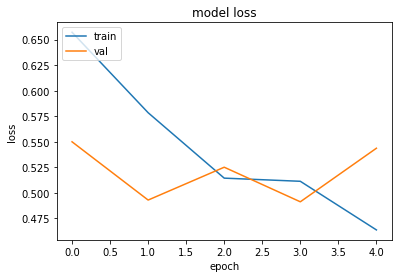

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
y_pred = model.predict(X_test_padded)
y_pred = np.round(y_pred)

In [73]:
accuracy_score(y_test, y_pred)

0.7005988023952096

In [74]:
confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0]),
        index=['True_pos', 'True_neg'], 
        columns=['Pred_pos', 'Pred_neg']
    )
confusion_matrix_df

,Pred_pos,Pred_neg
True_pos,31,35
True_neg,15,86


In [75]:
y_test.shape

(167,)

*Getting Negative Predictions from model for 1-NN & Cfs*

In [76]:
y_pred = y_pred.reshape(y_pred.shape[0])

In [77]:
X_pred_negative = X_test_padded[y_pred == 1]


In [78]:
X_pred_negative.shape

(46, 8)

In [79]:
# Model uses hamming distance, Training 1nn on positive instances
nn_model = NearestNeighbors(n_neighbors = 1, metric='hamming')
nn_model.fit(X_train_padded[y_train == 0])

NearestNeighbors(metric='hamming', n_neighbors=1)

In [87]:
X_pred_negative = X_test[y_pred == 1]

print('negative predictions',X_pred_negative[:3])
print('X_neg_predict shape', X_pred_negative.shape)

negative predictions [[ 2.66666667 19.79899497 14.28571429 16.66666667 14.59677419 11.09090909
   0.7107952  13.61702128]
 [13.33333333 16.88442211 15.10204082  0.          0.         13.81818182
   4.07818747  5.53191489]
 [17.33333333 10.65326633 14.69387755 20.          0.         13.30909091
   0.888494   10.21276596]]
X_neg_predict shape (46, 8)


In [88]:
closest = nn_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_train_padded[y_train == 0][closest[:, 0]]
print(trans_results_nn.shape)
print('closest counter to the negative prediction that can change it into a positive one',trans_results_nn[:3])

(46, 8)
closest counter to the negative prediction that can change it into a positive one [[ 1  7  7  3  1  6  2  0]
 [ 0  7  0  0  0  6  2  1]
 [ 0 10 11  4  0  8  6  3]]


#Evaluation Metrics

*Fraction* of valid CFs 

In [89]:
x_test_counter =  trans_results_nn
test_size = X_pred_negative.shape[0]
# For 1NN modification
fraction_success = np.sum(model.predict(x_test_counter) > 0.5)/test_size
print(round(fraction_success, 4))

0.0217


*Local* Outlier Factor

In [91]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
# clf.fit(X_train_padded)
clf.fit(X_train_padded[y_train == 0]) # use the target class to train, instead of all

LocalOutlierFactor(contamination=0.1, novelty=True)

In [92]:
# Outlier score for 1NN baseline method
y_pred_test = clf.predict(x_test_counter)
n_error_test = y_pred_test[y_pred_test == -1].size
outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.2609


*EDIT DISTANCE (LEVENSHTEIN)*

In [93]:

def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)

In [94]:
get_edit_distance(X_test_padded, X_pred_negative)

7.6304

In [95]:
get_edit_distance(trans_results_nn, X_pred_negative)

6.7609